# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.18 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. The Learning Algorithm

The algorithm used in this repository is an implementation of MultipleAgentDDPG (MADDPG), which allows for the trianing of two individual agents, one for each racket in this case, but trains them from a shared replay buffer. Each DDPG agent is implemented using an actor-critic methodology. The Actor suggests an action based on current state, but the critic during training can see the whole state of the board including the state of the other agent to estimate the action value chosen by the Actor. 

Due to the overlap between both agents, I have chosen to reuse code in the continuous control repository to instantiate each agent individually. I will then create a thrid class that controls the training of both agents  memory through a replay buffer, for which I will, again, reuse code. 

Please see https://github.com/dhruvnandakumar/actor-critic for code sources

### 4. Instantiating the DDPG Agents and Models 

In [5]:
hyperparameters = {
            "buffer_size":int(1e5),
            "batch_size":128,
            "gamma":0.99,
            "tau":1e-3,
            "lr_actor":2e-4,
            "lr_critic":2e-4,
            "weight_decay": 0, 
            "epsilon": 1,
            "epsilon_decay": 0.99
        }

In [6]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    
    def __init__(self, state_size, action_size, seed, hidden_size=128, hidden_size2=256):
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, action_size)
        self.set_weights()
        
    def set_weights(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        
        out = F.relu(self.fc1(state))
        out = self.bn(out)
        out = F.relu(self.fc2(out))
        return F.tanh(self.fc3(out))
    
class Critic(nn.Module):
    
    def __init__(self, state_size, action_size, seed, hidden_size=128, hidden_size2=128):
        
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size+(action_size), hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.set_weights() 
        
    def set_weights(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        if state.dim == 1:
            state = torch.unsqueeze(state, 0)
        
        out1 = F.relu(self.fc1(state))
        out1 = self.bn(out1)
        out = torch.cat((out1, action), dim=1)
        out = F.relu(self.fc2(out))
        return self.fc3(out)

In [7]:
import numpy as np
import random
import copy
import os
from collections import namedtuple, deque

# from model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    
    def __init__(self, state_size, action_size, seed, hparams, identity):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed) 
        self.hparams = hparams
        self.identity = identity
        
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.hparams["lr_actor"])
        
        for target_param, source_param in zip(self.actor_target.parameters(), self.actor_local.parameters()):
            target_param.data.copy_(source_param.data)
        
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=self.hparams["lr_critic"], weight_decay=self.hparams["weight_decay"])
        
        for target_param, source_param in zip(self.critic_target.parameters(), self.critic_local.parameters()):
            target_param.data.copy_(source_param.data)
        
        
        #Controller will handle shared memory
        self.memory = ReplayBuffer(action_size, self.hparams["buffer_size"], self.hparams["batch_size"], seed)
        self.noise = OUNoise(action_size, seed)
       
        
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        
        #Controller will handle concatenating the actions from each agent
        if not torch.is_tensor(states):
            states = torch.from_numpy(states).float().to(device)
            
        self.actor_local.eval()
        with torch.no_grad():
                action = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() * self.hparams['epsilon']
        return np.clip(action, -1, 1)
    
    # Handle step in controller
    def step(self, states, actions, rewards, next_states, dones, ep):
        self.memory.add(states, actions, rewards, next_states, dones)
        
        if len(self.memory) > self.hparams["batch_size"] and ep % 5 == 0 and ep > 100:
            for _ in range(4):
                experiences = self.memory.sample()
                self.learn(experiences)
                    
    
    def learn(self, experiences):
        
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (self.hparams["gamma"] * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target)
        self.soft_update(self.actor_local, self.actor_target)
        
        self.hparams['epsilon'] *= self.hparams['epsilon_decay']
    
    def reset(self):
        self.noise.reset()    
        
    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.hparams["tau"]*local_param.data + (1.0-self.hparams["tau"])*target_param.data)
            
    def print_models(self):
        print("Agent ", str(self.identity), " ", self.actor_local)
        print("Agent ", str(self.identity), " ", self.critic_local)
        
    def save_models(self):
        torch.save(self.actor_local.state_dict(), str(self.identity) + "_actor_weights.pth")
        torch.save(self.critic_local.state_dict(), str(self.identity) + "_critic_weights.pth")
        
    


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
    
    
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma        
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state        
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [8]:
class MADDPGController():
    
    def __init__(self, state_size, action_size, seed, hparams):
        self.seed = random.seed(seed)
        self.state_size = state_size 
        self.action_size = action_size 
        self.hparams = hparams 
        
        self.act0 = np.zeros(self.action_size)
        self.act1 = np.zeros(self.action_size)
        self.agents = [Agent(state_size, action_size, seed, hparams, identity) for identity in range(0,2)]
        
        
    def act(self, states):
        
        act0 = self.agents[0].act(states[0])
        act1 = self.agents[1].act(states[1])
        
        
        return [act0, act1]
    
        
    def step(self, states, actions, rewards, next_states, dones, ep):
        for i, agent in enumerate(self.agents):
            agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], ep)
        
                    
    def reset(self):
        for agent in self.agents:
            agent.reset()
            
    def print_models(self):
        for agent in self.agents:
            agent.print_models()
            
    def save_models(self):
        for agent in self.agents:
            agent.save_models()
                
        
                

### 5. Model structure and hyperparameters

The model structure and hyperparameters are as follows:

In [9]:
agent = MADDPGController(state_size, action_size, 42, hyperparameters)

In [10]:
agent.print_models()

Agent  0   Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)
Agent  0   Critic(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=130, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
Agent  1   Actor(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)
Agent  1   Critic(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentu

Hyperparameters are as follows: 

In [11]:
agent.hparams

{'buffer_size': 100000,
 'batch_size': 128,
 'gamma': 0.99,
 'tau': 0.001,
 'lr_actor': 0.0002,
 'lr_critic': 0.0002,
 'weight_decay': 0,
 'epsilon': 1,
 'epsilon_decay': 0.99}

### 6. Training the model

In [13]:
def train(episodes=10000, decision_boundary=1000):
    
    
    np.random.seed(42)
    torch.manual_seed(42)
    
    scores_deque = deque(maxlen=100)
    all_scores = []
    all_avg_score = []
    break_idx = episodes
    
    for idx in range(episodes):
        states = env.reset(train_mode=True)[brain_name].vector_observations
        agent.reset()
        scores = np.zeros(2)
        
        for _ in range(decision_boundary):
            
            if idx <= 100: #Get some random info to train with first 
                act0 = np.random.randn(action_size) # select an action (for each agent)
                act0 = np.clip(act0, -1, 1)
                
                act1 = np.random.randn(action_size)
                act1 = np.clip(act1, -1, 1)
                
                actions = [act0, act1]
                
            else:
                actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]  
            next_states = env_info.vector_observations  
            rewards = env_info.rewards                         
            dones = env_info.local_done 
            scores += rewards
            agent.step(states, actions, rewards, next_states, dones, idx)
            states = next_states 
            if np.any(dones):
                break
                
        score = np.max(scores)
        scores_deque.append(score)
        all_scores.append(score)
        all_avg_score.append(np.mean(scores_deque))
        print('\rEpisode {}\tAverage Score: {}\tCurrent Score: {}'.format(idx, np.mean(scores_deque), score), end="")
        
        if (idx > 100) and (np.mean(scores_deque) >=0.5):
            if break_idx == episodes:
                print('\n\nEnvirontment solved. Episode {}\tAverage Score: {}\tCurrent Score: {}\n'.format(idx-100, np.mean(scores_deque), score))
                agent.save_models()
                break_idx = idx
                
        if idx >= break_idx + 200: #Just to see what happens after we hit the goal
            break
    
    return all_scores, all_avg_score
        
            

In [14]:
scores, avgs = train()

Episode 1774	Average Score: 0.5069000076130032	Current Score: 0.8000000119209295862

Environtment solved. Episode 1674	Average Score: 0.5069000076130032	Current Score: 0.800000011920929

Episode 1974	Average Score: 1.3491000201553107	Current Score: 0.30000000447034836

### 7. Plotting scores and mean rewards 

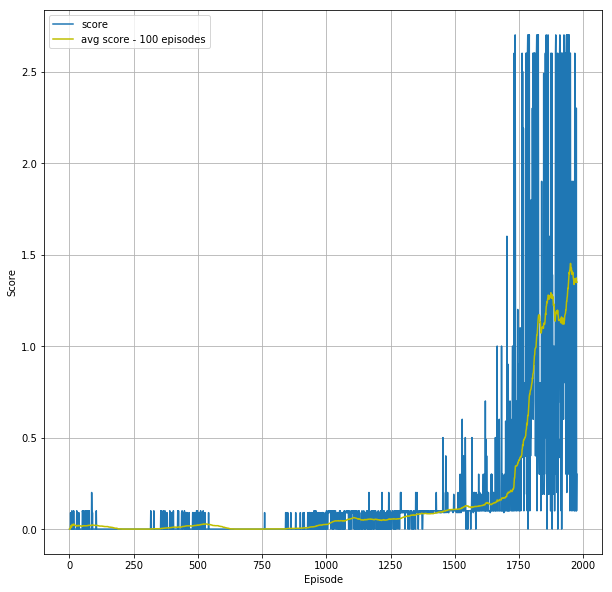

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label='score')
plt.plot(np.arange(1, len(scores)+1), avgs, c='y', label='avg score - 100 episodes')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.grid(True)
plt.legend(loc='upper left')
plt.savefig('rewards.png')
plt.show()

### 8. Ideas for future improvement 

For future implementations, I would like to:
1. Implement MADDPG with a single controller which can view the entire state space instead of a smaller view controller for each agent 
2. Implement, like in the benchmark solutoin, a single actor network instead of individual actor networks for each agent 
3. Dynamic hyperparameter optimization to see how different seeds and other parameters would affect the model 